# Convolutional Neural Network (CNN) on CIFAR-2 Class Data

In [1]:
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [24]:
import keras
print (keras.__version__)

1.2.0


## CIFAR-2 Dataset

In [2]:
train_data = pickle.load(open("CIFAR_2_train_data.pkl", 'rb'))
train_labels = pickle.load(open("CIFAR_2_train_labels.pkl", 'rb'))
test_data = pickle.load(open("CIFAR_2_test_data.pkl", 'rb'))
test_labels = pickle.load(open("CIFAR_2_test_labels.pkl", 'rb'))
print("Training data shape: {}".format(train_data.shape))
print("Training labels shape: {}".format(train_labels.shape))
print("Test data shape: {}".format(test_data.shape))
print("Test labels shape: {}".format(test_labels.shape))
label_dict = ["airplane", "cat"]
label_dict[0], label_dict[1]

Training data shape: (10000, 3, 32, 32)
Training labels shape: (10000, 2)
Test data shape: (2000, 3, 32, 32)
Test labels shape: (2000, 2)


('airplane', 'cat')

In [3]:
type(train_data)

numpy.ndarray

There are $10000$ training and $2000$ test samples; each has 32 $\times$ 32 pixels with 3 channels (from **RGB**: red, green and blue), represented by a $32 \times 32\times 3$ matrix with numbers of $0-255$. There are two labels: **airplane** or **cat**, so it is a binary classification problem.

In [5]:
print (len(train_data), len(test_data))

10000 2000


In [11]:
len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0])

(3, 32, 32)

In [10]:
test_data[0]

array([[[255, 255, 255, ..., 226, 224, 223],
        [253, 254, 255, ..., 225, 224, 223],
        [253, 255, 255, ..., 228, 227, 225],
        ..., 
        [167, 168, 169, ..., 106, 106, 108],
        [131, 115, 128, ...,  90,  92,  96],
        [121,  99, 112, ...,  98,  99, 101]],

       [[255, 255, 255, ..., 227, 225, 223],
        [253, 254, 255, ..., 226, 224, 223],
        [253, 255, 255, ..., 229, 227, 225],
        ..., 
        [168, 169, 170, ..., 101, 101, 103],
        [122, 106, 119, ...,  84,  86,  90],
        [116,  95, 107, ...,  90,  90,  92]],

       [[255, 255, 255, ..., 222, 222, 221],
        [253, 254, 255, ..., 221, 222, 221],
        [253, 255, 255, ..., 224, 224, 223],
        ..., 
        [171, 171, 173, ...,  75,  74,  75],
        [101,  85,  98, ...,  52,  56,  60],
        [ 94,  73,  85, ...,  56,  58,  61]]], dtype=uint8)

In [12]:
def plotExamples(data, labels, label_dict):
    plt.figure(figsize=(8,5))
    for i in range(8):
        sub = 241 + i
        ax = plt.subplot(sub)
        index = np.random.randint(0, data.shape[0])
        label_int = np.argmax(labels[index])
        ax.set_title(label_dict[label_int])
        im = data[index]
        im = np.transpose(im, (1, 2, 0))
        plt.imshow(im)
    plt.show()

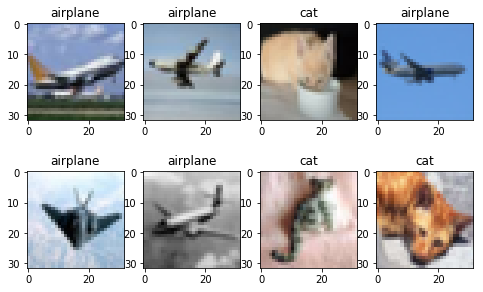

In [13]:
plotExamples(train_data, train_labels, label_dict)

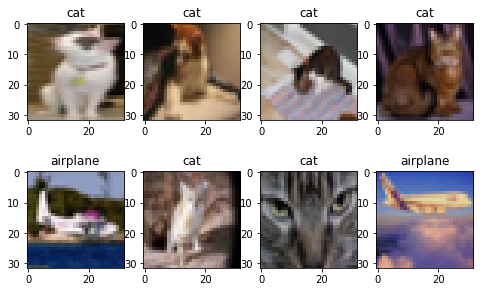

In [32]:
plotExamples(test_data, test_labels, label_dict)

## Keras Parameters

### 1. Parameter convention

For layers and filters we use the convention $x\time y \times z$, where $x$ and $y$ are length and width. $z$ is the depth. In each convolution process, the depth of each filter is always set to be the same as the depth of the layer.

### 2. Image dim ordering

The image dim ordering convention is slightly tricky in Keras. Suppose the input image dim is 32x32x3 (3 channels), and consider 64 3x3x3 filters in the convolutional layer. If we just naively follow [Keras instruction](https://keras.io/layers/convolutional/#convolution2d) to build a network, we will have an indication like this:

In [43]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(3, 32, 32)))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_75 (Convolution2D) (None, 3, 32, 64)     18496       convolution2d_input_32[0][0]     
Total params: 18,496
Trainable params: 18,496
Non-trainable params: 0
____________________________________________________________________________________________________


After the convolutional layer, we expect the output dim is 32x32x64, but now the output dimension is still 64x32x3. Since we are using 64 3x3x3 filters, there should be 64x3x3x3+3=1792 parameters. Above we have 18496, so the number of parameters is also not correct. Using **dim_ordering ='th'** in constructing models, we have

In [44]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(3, 32, 32), dim_ordering ='th'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_76 (Convolution2D) (None, 64, 32, 32)    1792        convolution2d_input_33[0][0]     
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
____________________________________________________________________________________________________


Now the output dim is 32x32x64 (depth becomes 64) and the number of parameters is 64x3x3x3+64=1792. In tensorflow, the input dim convention is 32x32x3. But in theano, it is 3x32x32, and keep in mind that we are using tensorflow as beackend now. Or, we can build the network obeying the tensorflow convention:

In [45]:
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_77 (Convolution2D) (None, 32, 32, 64)    1792        convolution2d_input_34[0][0]     
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
____________________________________________________________________________________________________


Now it is also consistent. Another way is to revise the file: **~/.keras/keras.json**,  change **"image_dim_ordering":"tf"** $\to$ **"image_dim_ordering": "th"**.

### 3. Zero-Padding

**border_mode = 'same'** is to make the input and output have the same length and width. Suppose input image is 32x32x3 again, but we have 32 3x3x3 filters. Without zero-padding, after convolution, the layer becomes 30x30x32

In [14]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), dim_ordering ='th'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 30, 30)    896         convolution2d_input_1[0][0]      
Total params: 896
Trainable params: 896
Non-trainable params: 0
____________________________________________________________________________________________________


Using each 3x3x3 filter to scan a 32x32x3 image, we only have a 30x30x1 layer. Zero-padding is proposed to make input and output layers have same sizes. This makes convlution process easier. In the current example, we do

In [15]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), dim_ordering ='th'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_2[0][0]      
Total params: 896
Trainable params: 896
Non-trainable params: 0
____________________________________________________________________________________________________


The output layer is still 32x32x32 (depth is 32 since there are 32 filters).

## Convolutional Network Architecture

In [26]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform', dim_ordering ='th'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform', dim_ordering ='th'))
model.add(MaxPooling2D((2,2), dim_ordering ='th'))
model.add(Flatten())
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_48 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_22[0][0]     
____________________________________________________________________________________________________
convolution2d_49 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_48[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_49[0][0]           
____________________________________________________________________________________________________
flatten_15 (Flatten)             (None, 16384)         0           maxpooling2d_21[0][0]            
___________________________________________________________________________________________

### Structure explanation:
* Input images: (32x32)x3.
* Convolution using 32 (3x3)x3 filters: $\to$ (32x32)x32, parameters needed (32 biased parameters): (3x3x3)x32+32 = 896.
* Convolution using 64 (3x3)x32 filters: $\to$ (32x32)x64, parameters needed (64 biased parameters): (3x3x32)x64+64 = 18496.
* Max 2x2 pooling: $\to$ (16x16)x64.
* Now input dimension is 16x16x64 = 16384 and perform fully connected network (no hidden layer).
* Binary classification, so output is 2-dimensional, parameters needed: 16384x2+2 = 32770.

### Training the network

In [27]:
sgd = SGD(lr=0.000001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=10, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 134s - loss: 5.8075 - acc: 0.6101 - val_loss: 3.4194 - val_acc: 0.7615
Epoch 2/10
8000/8000 [==============================] - 129s - loss: 3.5785 - acc: 0.7571 - val_loss: 2.6026 - val_acc: 0.8185
Epoch 3/10
8000/8000 [==============================] - 129s - loss: 2.9374 - acc: 0.7979 - val_loss: 2.6299 - val_acc: 0.8175
Epoch 4/10
8000/8000 [==============================] - 127s - loss: 2.8699 - acc: 0.8026 - val_loss: 2.3568 - val_acc: 0.8335
Epoch 5/10
8000/8000 [==============================] - 127s - loss: 2.5700 - acc: 0.8220 - val_loss: 2.3599 - val_acc: 0.8345
Epoch 6/10
8000/8000 [==============================] - 127s - loss: 2.5164 - acc: 0.8244 - val_loss: 2.2250 - val_acc: 0.8430
Epoch 7/10
8000/8000 [==============================] - 127s - loss: 2.3446 - acc: 0.8355 - val_loss: 2.1940 - val_acc: 0.8465
Epoch 8/10
8000/8000 [==============================] - 126s - 

### Testing 

In [29]:
scores = model.evaluate(test_data, test_labels);
print('  Loss: ', scores[0], ' , acc:', scores[1])

2000/2000 [==============================] - 15s    
  Loss:  2.2949956665  , acc: 0.837


## Other Network Architecture Examples

The above network only considers a **single** layer for the fully connected neural network, i.e. input-output. Now we can further add a **hidden** layer with 1024 neurons and relu activation function, i.e. input-hidden-output:

In [30]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform', dim_ordering ='th'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform', dim_ordering ='th'))
model.add(MaxPooling2D((2,2), dim_ordering ='th'))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform'))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=10, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_50 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_23[0][0]     
____________________________________________________________________________________________________
convolution2d_51 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_50[0][0]           
____________________________________________________________________________________________________
maxpooling2d_22 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_51[0][0]           
____________________________________________________________________________________________________
flatten_16 (Flatten)             (None, 16384)         0           maxpooling2d_22[0][0]            
___________________________________________________________________________________________

The numbers of parameters for the fully connected network are $\Big(16384\times1024 + 1024\Big) = 16778240$ and $\Big( 1024 \times 2+2\Big)=2050$ for the hidden and output layers, respectively.

In [31]:
scores = model.evaluate(test_data, test_labels);
print('  Loss: ', scores[0], ' , acc:', scores[1])

2000/2000 [==============================] - 21s    
  Loss:  1.96334595573  , acc: 0.8595


## More Convolutional Layers

In [36]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform', dim_ordering ='th'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform', dim_ordering ='th'))
model.add(MaxPooling2D((2,2), dim_ordering ='th'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform', dim_ordering ='th'))
model.add(Convolution2D(128, 3, 3, border_mode='same', init='lecun_uniform', dim_ordering ='th'))
model.add(MaxPooling2D((2,2), dim_ordering ='th'))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform'))
model.add(Dense(512, activation='relu', init='lecun_uniform'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
## training
sgd = SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=10, validation_split=0.2)
## testing
scores = model.evaluate(test_data, test_labels);
print('  Loss: ', scores[0], ' , acc:', scores[1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_68 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_28[0][0]     
____________________________________________________________________________________________________
convolution2d_69 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_68[0][0]           
____________________________________________________________________________________________________
maxpooling2d_31 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_69[0][0]           
____________________________________________________________________________________________________
convolution2d_70 (Convolution2D) (None, 64, 16, 16)    36928       maxpooling2d_31[0][0]            
___________________________________________________________________________________________

In [38]:
sgd = SGD(lr=0.00001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=10, validation_split=0.2)
## testing
scores = model.evaluate(test_data, test_labels);
print('  Loss: ', scores[0], ' , acc:', scores[1])

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 235s - loss: 1.8330 - acc: 0.8804 - val_loss: 1.9305 - val_acc: 0.8745
Epoch 2/10
8000/8000 [==============================] - 234s - loss: 1.7872 - acc: 0.8825 - val_loss: 1.9185 - val_acc: 0.8740
Epoch 3/10
8000/8000 [==============================] - 234s - loss: 1.7932 - acc: 0.8828 - val_loss: 1.9085 - val_acc: 0.8755
Epoch 4/10
8000/8000 [==============================] - 234s - loss: 1.7582 - acc: 0.8841 - val_loss: 1.9150 - val_acc: 0.8745
Epoch 5/10
8000/8000 [==============================] - 233s - loss: 1.6889 - acc: 0.8875 - val_loss: 1.7848 - val_acc: 0.8810
Epoch 6/10
8000/8000 [==============================] - 233s - loss: 1.7227 - acc: 0.8859 - val_loss: 1.8128 - val_acc: 0.8795
Epoch 7/10
8000/8000 [==============================] - 233s - loss: 1.6645 - acc: 0.8904 - val_loss: 1.7333 - val_acc: 0.8840
Epoch 8/10
8000/8000 [==============================] - 233s - 

In [39]:
sgd = SGD(lr=0.000001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=20, validation_split=0.2)
## testing
scores = model.evaluate(test_data, test_labels);
print('  Loss: ', scores[0], ' , acc:', scores[1])

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 244s - loss: 1.5642 - acc: 0.8944 - val_loss: 1.7066 - val_acc: 0.8875
Epoch 2/20
8000/8000 [==============================] - 249s - loss: 1.5200 - acc: 0.8978 - val_loss: 1.7232 - val_acc: 0.8820
Epoch 3/20
8000/8000 [==============================] - 233s - loss: 1.5149 - acc: 0.8971 - val_loss: 1.7103 - val_acc: 0.8830
Epoch 4/20
8000/8000 [==============================] - 234s - loss: 1.5042 - acc: 0.8994 - val_loss: 1.6910 - val_acc: 0.8845
Epoch 5/20
8000/8000 [==============================] - 233s - loss: 1.5118 - acc: 0.8981 - val_loss: 1.6902 - val_acc: 0.8845
Epoch 6/20
8000/8000 [==============================] - 234s - loss: 1.5345 - acc: 0.8975 - val_loss: 1.6920 - val_acc: 0.8855
Epoch 7/20
8000/8000 [==============================] - 233s - loss: 1.5190 - acc: 0.8986 - val_loss: 1.6901 - val_acc: 0.8850
Epoch 8/20
8000/8000 [==============================] - 233s - 